In [102]:
import netCDF4 as nc
import numpy as np
import matplotlib.pylab as plt

from matplotlib.pyplot import rcParams
%matplotlib inline
plt.rcParams['figure.figsize']=(20,12)


In [111]:
WFDEI_DIR='/users/eow/edwcom/WFD_EI/'

# New 2D ancil files
ANCIL_DIR=WFDEI_DIR+'ANCILS_albmar201610/'
Frac_file=ANCIL_DIR+'frac_igbp_0p5deg_ancil9.0_wfdei.nc'
Soil_file=ANCIL_DIR+'soil_igbp_bc_0p5deg_ancil9.0_wfdei.nc'
Func_file=ANCIL_DIR+'func_igbp_0p5deg_ancil9.0_wfdei.nc'
LandFrac_file=ANCIL_DIR+'wfdei_landfrac_land_only.nc'

# Old 1D dump files for gap filling
OLD_Dump_file=WFDEI_DIR+'Jv4.5_WFDEI_nti_NG-HWSD.dump.19800101.0.nc'


grid_file=WFDEI_DIR+'EI-Halfdeg-land-elevation.nc' 
gridCHECK_file=WFDEI_DIR+'wfdei-land-mask.nc' 

lat_name='latitude'
lon_name='longitude'

fill_value=-999.

In [60]:
#read grid file
grinf=nc.Dataset(grid_file,'r')
grlons=grinf.variables[lon_name][:]
grlats=grinf.variables[lat_name][:]
Grid_lat=grinf.variables['Grid_lat'][:]
Grid_lon=grinf.variables['Grid_lon'][:]
grinf.close()

grindex=nc.Dataset(gridCHECK_file,'r').variables['land_index'][:]

In [136]:
# Read in old dump data for checking and gap filling
DumpDict={}
Dinf=nc.Dataset(OLD_Dump_file,'r')
outvars=[]
for var in Dinf.variables:
    DumpDict[var]=Dinf.variables[var][:]
    outvars.append(var)
Dinf.close()

print(outvars)


['canopy', 'cs', 'gs', 'snow_tile', 'sthuf', 't_soil', 'tstar_tile', 'sthzw', 'zw', 'rho_snow', 'snow_depth', 'snow_grnd', 'nsnow', 'snow_ds', 'snow_ice', 'snow_liq', 'tsnow', 'frac', 'b', 'sathh', 'satcon', 'sm_sat', 'sm_crit', 'sm_wilt', 'hcap', 'hcon', 'albsoil', 'fexp', 'ti_mean', 'ti_sig', 'frac_agr', 'co2_mmr', 'latitude', 'longitude']


In [132]:

outf.close()

In [129]:
print(DumpDict['frac'].shape)
print(Data_1D.shape)
print(var)


(9, 67209)
(9, 67209)
frac


In [159]:
# Frac data, in-dims=(psuedo,lat,lon)
# open in file for reference
inf=nc.Dataset(Frac_file,'r')

# Variables to convert:
var='frac'
ntile=len(inf.dimensions['pseudo'])
nland=len(grlats)

# Open outfile and create dimensions (tile,land)
outf=nc.Dataset(Frac_file[:-2]+'landpoints.nc','w')
outf.createDimension('tile',ntile)
outf.createDimension('land',nland)

invar=inf.variables[lat_name]
outvar=outf.createVariable(lat_name,'float32',('land'),fill_value=fill_value)
for att in invar.ncattrs():
    outvar.setncattr(att,invar.getncattr(att))
outvar[:]=grlats
    
invar=inf.variables['lon']
outvar=outf.createVariable(lon_name,'float32',('land'),fill_value=fill_value)
for att in invar.ncattrs():
    outvar.setncattr(att,invar.getncattr(att))
outvar[:]=grlons

invar=inf.variables[var]
Data_2D=invar[:].data
in_FV=invar[:].fill_value
inlats=inf.variables[lat_name][:]
inlons=inf.variables['lon'][:]
Data_1D=np.zeros([ntile,nland])
for i,lat,lon in zip(range(len(grlats)),grlats,grlons):
    x_index=np.where(inlons==lon)[0]
    y_index=np.where(inlats==lat)[0]
    Data_1D[:,i]=Data_2D[:,y_index,x_index].squeeze()

Data_1D[Data_1D==in_FV]=DumpDict[var][Data_1D==in_FV]

outvar=outf.createVariable(var,'float32',('tile','land'),fill_value=fill_value)
for att in invar.ncattrs():
    print(att)
    outvar.setncattr(att,invar.getncattr(att))
outvar[:]=Data_1D

for att in inf.ncattrs():
    outf.setncattr(att,inf.getncattr(att))

outf.note2='Put onto WFDEI land points and filled by Edward Comyn-Platt (edwcom@ceh.ac.uk) Yeahhhh boiiiii!'

outf.close()
inf.close()


In [135]:
# Soil data, in-dims=(lat,lon)
# open in file for reference
inf=nc.Dataset(Soil_file,'r')
invars=[]
for var in inf.variables:
    invars.append(str(var))
print(invars)
inf.close()


['latitude', 'lon', 'vwilt', 'vcrit', 'vsat', 'bexp', 'sathh', 'satcon', 'hcon', 'hcap', 'albsoil', 'csoil']


In [158]:
# Soil data, in-dims=(lat,lon)
# open in file for reference
inf=nc.Dataset(Soil_file,'r')

# Variables to convert:
invars=['vwilt', 'vcrit', 'vsat', 'bexp', 'sathh', 'satcon',\
        'hcon', 'hcap', 'albsoil', 'csoil']
outvars=['sm_wilt', 'sm_crit', 'sm_sat', 'b', 'sathh', 'satcon', \
         'hcon', 'hcap', 'albsoil', 'cs']

#ntile=len(inf.dimensions['pseudo'])
nland=len(grlats)

# Open outfile and create dimensions (tile,land)
outf=nc.Dataset(Soil_file[:-2]+'landpoints.nc','w')
outf.createDimension('land',nland)

invar=inf.variables[lat_name]
outvar=outf.createVariable(lat_name,'float32',('land'),fill_value=fill_value)
for att in invar.ncattrs():
    outvar.setncattr(att,invar.getncattr(att))
outvar[:]=grlats
    
invar=inf.variables['lon']
outvar=outf.createVariable(lon_name,'float32',('land'),fill_value=fill_value)
for att in invar.ncattrs():
    outvar.setncattr(att,invar.getncattr(att))
outvar[:]=grlons

inlats=inf.variables[lat_name][:]
inlons=inf.variables['lon'][:]
for ivar,ovar in zip(invars,outvars):
    print(ivar,ovar)
    invar=inf.variables[ivar]
    Data_2D=invar[:].data
    in_FV=invar[:].fill_value
    Data_1D=np.zeros([nland])
    for i,lat,lon in zip(range(len(grlats)),grlats,grlons):
        x_index=np.where(inlons==lon)[0]
        y_index=np.where(inlats==lat)[0]
        Data_1D[i]=Data_2D[y_index,x_index].squeeze()
        
    # Fill from old dump file
    if ovar in ['albsoil']:
        Data_1D[Data_1D==in_FV]=DumpDict[ovar][Data_1D==in_FV]
    else:
        Data_1D[Data_1D==in_FV]=DumpDict[ovar][0,Data_1D==in_FV]
    
    outvar=outf.createVariable(ovar,'float32',('land'),fill_value=fill_value)
    for att in invar.ncattrs():
        outvar.setncattr(att,invar.getncattr(att))
    outvar[:]=Data_1D

for att in inf.ncattrs():
    outf.setncattr(att,inf.getncattr(att))

outf.note2='Put onto WFDEI land points and filled by Edward Comyn-Platt (edwcom@ceh.ac.uk) Yeahhhh boiiiii!'

outf.close()
inf.close()


vwilt sm_wilt
vcrit sm_crit
vsat sm_sat
bexp b
sathh sathh
satcon satcon
hcon hcon
hcap hcap
albsoil albsoil
csoil cs


In [172]:
inf=nc.Dataset(Func_file,'r')

# Variables to convert:
invars=['leaf_area_index','canopy_height']
outvars=['lai','canht']

ntime=12
npft=5

inlats=inf.variables[lat_name][:]
inlons=inf.variables['lon'][:]
for ivar,ovar in zip([invars[0]],[outvars[0]]):
    print(ivar,ovar)
    invar=inf.variables[ivar]
    Data_2D=invar[:]
    #in_FV=invar[:].fill_value
    Data_1D=np.zeros([ntime,npft,nland])
    for i,lat,lon in zip(range(len(grlats)),grlats,grlons):
        x_index=np.where(inlons==lon)[0]
        y_index=np.where(inlats==lat)[0]
        Data_1D[:,:,i]=Data_2D[:,:,y_index,x_index].squeeze()
    
    
    


leaf_area_index lai


In [179]:
#for itime in range(ntime):
#    for ipft in range(npft):
# bad data is geographicm, so repeats for all time and pft indices
badex=np.where(Data_1D[0,0,:]<0)[0]
goodex=np.where(Data_1D[0,0,:]>=0)[0]
for pt in badex:
    temppoint = np.argmin(  ((grlats[pt]-grlats[goodex])**2) \
                          + ((grlons[pt]-grlons[goodex])**2) )
    new_point=goodex[temppoint]
    Data_1D[:,:,pt]=Data_1D[:,:,new_point]


(67209,)
<class 'numpy.ma.core.MaskedArray'>
[[-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 ..., 
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]]


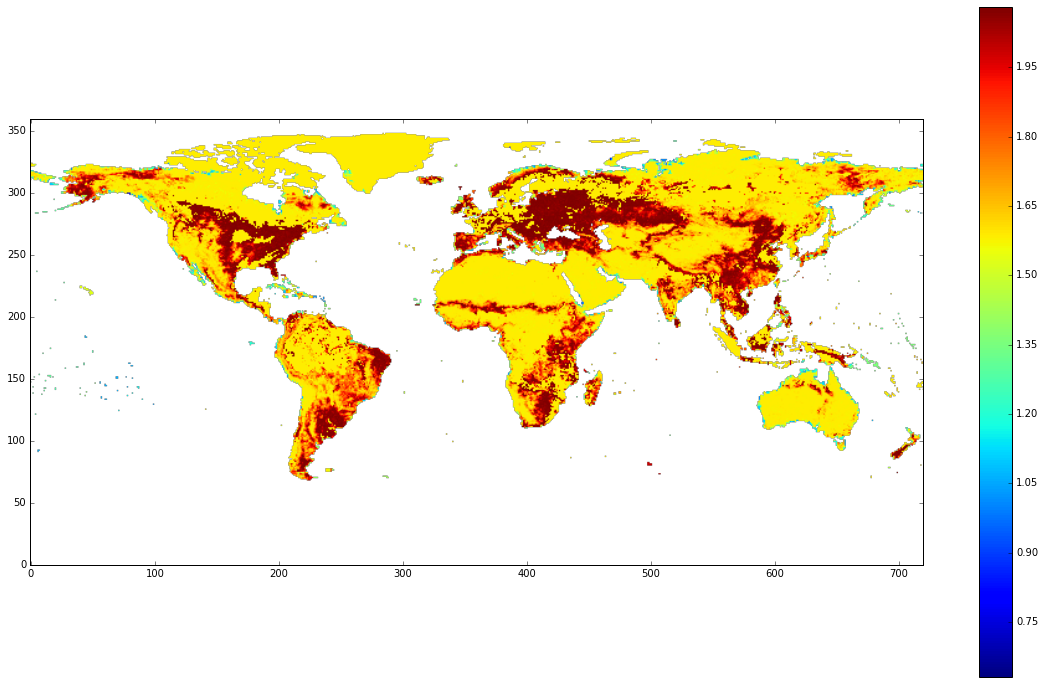

In [193]:
#Data_1D.mask[:]=False
test_data=Data_1D[3,4,:].copy()
print(test_data.shape)
#print(len(np.where(test_data.mask==True)[0]))
print(type(grindex))
test_data=np.ma.masked_array(test_data[grindex-1],mask=grindex.mask)
print(test_data)
#test_data.mask[:]=np.zeros_like(test_data.data)
plt.imshow(test_data,origin='bottom')
plt.colorbar()

#len(np.where(test_data.mask==True)[0])


In [187]:
# Veg Func data, in-dims=(time,pft,lat,lon)
#                       (12,5,360,720)
# open in file for reference
inf=nc.Dataset(Func_file,'r')

# Variables to convert:
invars=['leaf_area_index','canopy_height']
outvars=['lai','canht']

#ntile=len(inf.dimensions['pseudo'])
nland=len(grlats)
ntime=len(inf.dimensions['time'])
npft=len(inf.dimensions['pft'])

# Open outfile and create dimensions (tile,land)
outf=nc.Dataset(Func_file[:-2]+'landpoints.nc','w')
outf.createDimension('land',nland)
outf.createDimension('time',ntime)
outf.createDimension('pft',npft)

invar=inf.variables[lat_name]
outvar=outf.createVariable(lat_name,'float32',('land'),fill_value=fill_value)
for att in invar.ncattrs():
    outvar.setncattr(att,invar.getncattr(att))
outvar[:]=grlats
    
invar=inf.variables['lon']
outvar=outf.createVariable(lon_name,'float32',('land'),fill_value=fill_value)
for att in invar.ncattrs():
    outvar.setncattr(att,invar.getncattr(att))
outvar[:]=grlons

inlats=inf.variables[lat_name][:]
inlons=inf.variables['lon'][:]
for ivar,ovar in zip(invars,outvars):
    print(ivar,ovar)
    invar=inf.variables[ivar]
    Data_2D=invar[:]
    Data_1D=np.zeros([ntime,npft,nland])
    for i,lat,lon in zip(range(len(grlats)),grlats,grlons):
        x_index=np.where(inlons==lon)[0]
        y_index=np.where(inlats==lat)[0]
        Data_1D[:,:,i]=Data_2D[:,:,y_index,x_index].squeeze()
    
    # Fill data with closest neighbour
    # bad data is geographic, so repeat for all time and pft indices
    badex=np.where(Data_1D[0,0,:]<0)[0]
    goodex=np.where(Data_1D[0,0,:]>=0)[0]
    for pt in badex:
        temppoint = np.argmin(  ((grlats[pt]-grlats[goodex])**2) \
                              + ((grlons[pt]-grlons[goodex])**2) )
        new_point=goodex[temppoint]
        Data_1D[:,:,pt]=Data_1D[:,:,new_point]
    
    outvar=outf.createVariable(ovar,'float32',('time','pft','land'),fill_value=fill_value)
    for att in invar.ncattrs():
        outvar.setncattr(att,invar.getncattr(att))
    outvar[:]=Data_1D

for att in inf.ncattrs():
    outf.setncattr(att,inf.getncattr(att))

outf.note2='Put onto WFDEI land points and filled by Edward Comyn-Platt (edwcom@ceh.ac.uk) Yeahhhh boiiiii!'

outf.close()
inf.close()


leaf_area_index lai
canopy_height canht


In [186]:
outf.close()